In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tcn import TCN, tcn_full_summary
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


In [56]:
data = pd.read_csv('merged_all_final.csv')

In [57]:
X = data[['Time (s)','A_x', 'A_y', 'A_z', 'Gyr_x', 'Gyr_y', 'Gyr_z', 'freq', 'speed']]
y = data['state']

In [58]:
# Reshape X to be 3D 
X = X.values.reshape((X.shape[0], X.shape[1], 1))

# Initialize the label encoder
le = LabelEncoder()

# Fit the label encoder and transform the target variable
y = le.fit_transform(y)

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
# Define the learning rate
learning_rate = 0.001

# Define model
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(4, activation='softmax'))  # 4 is the number of categories

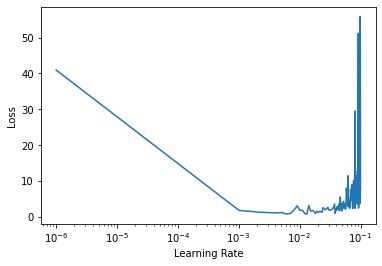

In [40]:
#Learning rate test
def learning_rate_range_test(X_train, y_train, lr_start, lr_end, num_epochs):
    # define range of learning rate
    lrs = np.linspace(lr_start, lr_end, num_epochs)
    
    losses = []
    for lr in lrs:
        # define model
        model = Sequential()
        model.add(LSTM(40, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(4, activation='softmax'))
        
        # compile model
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # train model
        history = model.fit(X_train, y_train, epochs=1, verbose=0)
        
        # loss value
        losses.append(history.history['loss'][0])
    
    return lrs, losses

lr_start = 1e-6  # start learning rate
lr_end = 1e-1    # end learning rate
num_epochs = 100  # epochs

lrs, losses = learning_rate_range_test(X_train, y_train, lr_start, lr_end, num_epochs)

# 
plt.plot(lrs, losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.show()

In [60]:
# Compile model with adjustable learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_test, y_test))

# get features importance
feature_importance = model.layers[0].get_weights()[0].sum(axis=0)

In [61]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.06244322285056114
Test accuracy: 0.9866982102394104


In [62]:
feature_names = ['Time (s)', 'A_x', 'A_y', 'A_z', 'Gyr_x', 'Gyr_y', 'Gyr_z', 'freq', 'speed']
for i in range(len(feature_importance)):
    print(f"Feature '{feature_names[i]}': Importance = {feature_importance[i]}")

Feature 'Time (s)': Importance = 0.1261570155620575
Feature 'A_x': Importance = 0.2927938401699066
Feature 'A_y': Importance = 0.0660049244761467
Feature 'A_z': Importance = -0.11049182713031769
Feature 'Gyr_x': Importance = -0.05919549614191055
Feature 'Gyr_y': Importance = 0.051055822521448135
Feature 'Gyr_z': Importance = 0.39146342873573303
Feature 'freq': Importance = 0.959500253200531
Feature 'speed': Importance = 0.850762665271759


IndexError: list index out of range

106/106 [==============================] - 0s 1ms/step


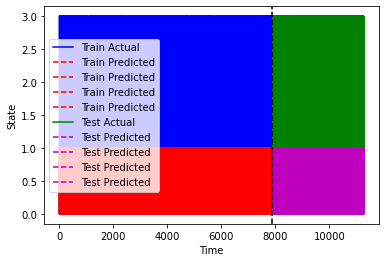

In [49]:
#this part is useless
# 获取训练集和测试集的时间序列数据
train_actual = y_train
train_predicted = model.predict(X_train)
test_actual = y_test
test_predicted = model.predict(X_test)

# 创建时间序列
time = range(len(train_actual) + len(test_actual))

# 绘制训练集实际值和预测值
plt.plot(time[:len(train_actual)], train_actual, 'b-', label='Train Actual')
plt.plot(time[:len(train_actual)], train_predicted, 'r--', label='Train Predicted')

# 绘制测试集实际值和预测值
plt.plot(time[len(train_actual):], test_actual, 'g-', label='Test Actual')
plt.plot(time[len(train_actual):], test_predicted, 'm--', label='Test Predicted')

# 添加图例和标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('State')

# 添加训练集和测试集标记
plt.axvline(len(train_actual), color='k', linestyle='--')

# 显示图形
plt.show()